In [1]:
# %pip install pandas scikit-learn matplotlib numpy
# %pip install tensorflow[and-cuda]

In [23]:
import pandas as pd
import tensorflow as tf
from tensorflow.keras.models import load_model
from tensorflow.keras.optimizers import Adam
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from random import shuffle

from model_creation import create_cnn_lstm_model, create_cnn_gru_model


In [3]:
from gpu_check.gpu_check import gpu_check

gpu_check()

Available devices:  [PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU')]
GPU available:  []
Num GPUs Available:  0
TensorFlow is using GPU:  False
TensorFlow is built with CUDA:  False
GPU name:  
Available devices:  [PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU')]
GPU available:  []
Num GPUs Available:  0
TensorFlow is using GPU:  False
TensorFlow is built with CUDA:  False
GPU name:  


In [4]:
data_full = pd.read_csv("data_cleaned.csv", header=0)
data_full['DATE (MM/DD/YYYY)'] = pd.to_datetime(data_full['DATE (MM/DD/YYYY)'], format='%Y-%m-%d %H:%M:%S')
data_full.set_index('DATE (MM/DD/YYYY)', inplace=True)

# Resample data to 1-hour intervals using mean
data_full = data_full.resample('1h').mean()
data_full.drop(columns=[
   'Global CMP22 (vent/cor) [W/m^2]',
   'Global CM6b (cor) [W/m^2]',
   'Global CM3 (cor) [W/m^2]',
   'Global PSP (vent/cor) [W/m^2]',
   'Global LI-200 [W/m^2]',
   'Global TSP-700 Vent [W/m^2]',
   'Global SP Lite2 [W/m^2]',
   'Global SP-110 [W/m^2]',
   # 'Tower Wet Bulb Temp [deg C]',
   # 'Total Cloud Cover [%]',
   # 'Direct Extraterrestrial (calc) [W/m^2]',
   # 'Tower Wind Chill Temp [deg C]'
], inplace=True)

print("Original data shape:", data_full.shape)
print("Hourly data shape:", data_full.shape)
data_full.head()

data_full

Original data shape: (96408, 18)
Hourly data shape: (96408, 18)


,Zenith Angle [degrees],Azimuth Angle [degrees],Airmass,Tower Dry Bulb Temp [deg C],Tower Wet Bulb Temp [deg C],Tower Dew Point Temp [deg C],Tower Wind Chill Temp [deg C],Tower RH [%],Total Cloud Cover [%],Opaque Cloud Cover [%],Avg Wind Speed @ 19ft [m/s],Peak Wind Speed @ 19ft [m/s],Avg Wind Direction @ 19ft [deg from N],Vertical Wind Shear [1/s],Station Pressure [mBar],Global Extraterrestrial (calc) [W/m^2],Direct Extraterrestrial (calc) [W/m^2],GHI Mean
DATE (MM/DD/YYYY),,,,,,,,,,,,,,,,,,
2013-01-01 00:00:00,162.061916,48.851776,0.0,-10.217333,-10.788450,-12.201783,-10.372317,64.180000,0.0,0.0,1.276650,1.473333,294.553000,0.005283,814.118900,0.0,0.0,0.0
2013-01-01 01:00:00,155.260928,52.772045,0.0,-9.942333,-10.770533,-12.917200,-12.229850,64.180000,0.0,0.0,1.851000,2.208333,287.896667,0.054000,814.277883,0.0,0.0,0.0
2013-01-01 02:00:00,145.059934,71.999074,0.0,-9.289833,-10.406217,-13.334550,-13.633083,64.180000,0.0,0.0,2.900233,3.491667,303.628333,0.111117,814.736583,0.0,0.0,0.0
2013-01-01 03:00:00,133.800905,84.478356,0.0,-9.421500,-10.295600,-12.518933,-10.072533,64.180000,0.0,0.0,1.759433,2.195833,307.818417,0.083033,815.411833,0.0,0.0,0.0
2013-01-01 04:00:00,122.297441,94.248839,0.0,-9.732167,-10.445833,-12.234167,-10.808300,64.180000,0.0,0.0,1.278550,1.654167,178.474267,0.032700,815.824267,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-12-31 19:00:00,120.584151,264.280572,0.0,-0.305350,-2.612400,-6.035733,-0.362133,61.720167,0.0,0.0,0.873817,1.358333,33.620367,0.083250,818.427750,0.0,0.0,0.0
2023-12-31 20:00:00,132.083604,273.811519,0.0,-0.962350,-2.989533,-6.019533,-0.962350,65.196167,0.0,0.0,0.336817,0.700000,150.711667,0.014883,818.463050,0.0,0.0,0.0
2023-12-31 21:00:00,143.414297,285.688949,0.0,-1.150100,-3.071867,-5.980200,-1.150100,66.442667,0.0,0.0,0.697667,0.970833,302.268700,0.000100,818.509700,0.0,0.0,0.0


In [5]:
def bad_correlation_with_output(dataset, threshold):
   col_corr = set()  # Set of all the names of correlated columns
   corr_matrix = dataset.corr(method='spearman')  # Calculate Spearman correlation
   num_columns = len(corr_matrix.columns) 
   for i in range(num_columns):
      if i != 0:
         if abs(corr_matrix.iloc[i,17 ]) < threshold:
               colname = corr_matrix.columns[i]
               col_corr.add(colname)
   return col_corr

bad_features = bad_correlation_with_output(data_full, 0.2)
data_full.drop(columns=bad_features, inplace=True)
data_full


,Zenith Angle [degrees],Airmass,Tower Dry Bulb Temp [deg C],Tower Wet Bulb Temp [deg C],Tower Wind Chill Temp [deg C],Tower RH [%],Total Cloud Cover [%],Opaque Cloud Cover [%],Avg Wind Direction @ 19ft [deg from N],Global Extraterrestrial (calc) [W/m^2],Direct Extraterrestrial (calc) [W/m^2],GHI Mean
DATE (MM/DD/YYYY),,,,,,,,,,,,
2013-01-01 00:00:00,162.061916,0.0,-10.217333,-10.788450,-10.372317,64.180000,0.0,0.0,294.553000,0.0,0.0,0.0
2013-01-01 01:00:00,155.260928,0.0,-9.942333,-10.770533,-12.229850,64.180000,0.0,0.0,287.896667,0.0,0.0,0.0
2013-01-01 02:00:00,145.059934,0.0,-9.289833,-10.406217,-13.633083,64.180000,0.0,0.0,303.628333,0.0,0.0,0.0
2013-01-01 03:00:00,133.800905,0.0,-9.421500,-10.295600,-10.072533,64.180000,0.0,0.0,307.818417,0.0,0.0,0.0
2013-01-01 04:00:00,122.297441,0.0,-9.732167,-10.445833,-10.808300,64.180000,0.0,0.0,178.474267,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...
2023-12-31 19:00:00,120.584151,0.0,-0.305350,-2.612400,-0.362133,61.720167,0.0,0.0,33.620367,0.0,0.0,0.0
2023-12-31 20:00:00,132.083604,0.0,-0.962350,-2.989533,-0.962350,65.196167,0.0,0.0,150.711667,0.0,0.0,0.0
2023-12-31 21:00:00,143.414297,0.0,-1.150100,-3.071867,-1.150100,66.442667,0.0,0.0,302.268700,0.0,0.0,0.0


In [27]:
data = data_full.values

# Calculate the split indices
train_size = int(0.92 * len(data))
val_test_size = len(data) - train_size
val_size = val_test_size // 2

# Split the data
train_data = data[:train_size]
val_data = data[train_size:train_size + val_size]
test_data = data[train_size + val_size:]


# Create datasets
sequence_length = 24
def create_dataset(data_array, batch_size=24, sequence_length=sequence_length):
   dataset = []
   
   for i in range(len(data_array) - sequence_length):
      dataset.append(data_array[i:i+sequence_length])
   
   shuffle(dataset)
   dataset = tf.data.Dataset.from_tensor_slices(dataset)
   dataset = dataset.batch(batch_size)
   
   return dataset

train_dataset = create_dataset(train_data)
val_dataset = create_dataset(val_data)
test_dataset = create_dataset(test_data)

# Print the size of dataset
print("Train dataset:", len(train_dataset))
print("Validation dataset:", len(val_dataset))
print("Test dataset:", len(test_dataset))

# Display a sample from the train dataset
for batch in train_dataset.take(1):
   first_batch = batch.numpy()  # Convert to numpy array
   
sample_sequence = first_batch[0]  # Get first sequence in batch
df_sample = pd.DataFrame(sample_sequence, 
                        columns=[f'Feature_{i+1}' for i in range(sample_sequence.shape[1])])
print("\nSample sequence from training data:")
display(df_sample)

print("\nDataset shapes:")
print(f"Train dataset batch shape: {next(iter(train_dataset)).shape}")
print(f"Validation dataset batch shape: {next(iter(val_dataset)).shape}")
print(f"Test dataset batch shape: {next(iter(test_dataset)).shape}")

Train dataset: 3695
Validation dataset: 160
Test dataset: 160

Sample sequence from training data:


,Feature_1,Feature_2,Feature_3,Feature_4,Feature_5,Feature_6,Feature_7,Feature_8,Feature_9,Feature_10,Feature_11,Feature_12
0,59.157889,1.954183,17.380167,6.597117,17.380167,19.581000,29.350000,16.216667,112.968333,706.098250,1378.231383,518.352490
1,53.116886,1.665219,19.656000,7.585683,19.656000,16.883833,45.000000,27.100000,99.174667,826.989817,1378.263667,577.166737
2,50.270824,1.562288,21.225167,7.953517,21.225167,13.813667,45.000000,30.000000,98.396000,880.936650,1378.295783,656.721125
3,51.165310,1.592821,21.910667,8.036583,21.910667,12.252667,45.000000,30.000000,51.117600,864.228833,1378.328017,555.425571
4,55.618693,1.771442,22.109167,8.662983,22.109167,14.705500,45.000000,30.000000,23.811817,777.998683,1378.360167,505.045260
5,62.863259,2.201230,21.597167,8.543517,21.597167,15.700667,45.000000,30.000000,25.218167,628.150550,1378.392417,359.316158
6,72.017621,3.289316,20.825000,8.513667,20.825000,18.035833,44.050000,27.500000,24.489833,425.029000,1378.424600,241.410156
7,82.339921,5.180634,19.141833,7.982433,19.141833,21.074333,32.400000,18.200000,32.745733,183.476567,1378.456783,88.092179
8,93.463654,1.939509,16.685333,6.809200,16.685333,23.948833,0.000000,0.000000,221.355267,6.218817,321.644550,2.766535
9,105.016404,0.000000,15.899167,6.394100,15.894783,24.815500,0.000000,0.000000,302.856667,0.000000,0.000000,0.000000



Dataset shapes:
Train dataset batch shape: (24, 24, 12)
Validation dataset batch shape: (24, 24, 12)
Test dataset batch shape: (24, 24, 12)


In [ ]:
# Determine input shape and number of features
num_features = data.shape[1]  # number of features in your data
input_shape = (sequence_length, num_features)

# Compile the model
model_cnn_gru = create_cnn_gru_model(input_shape, num_features)
optimizer = Adam(learning_rate=0.001)
model_cnn_gru.compile(optimizer=optimizer, loss='mse', metrics=['mae'])

model_cnn_gru.summary()

# Train the model
history = model_cnn_gru.fit(
   train_dataset,
   validation_data=val_dataset,
   epochs=60,
   batch_size=24,
   verbose=1
)

# Save model architecture
model_cnn_gru.save('model_cnn_gru.keras')
with open("model_cnn_gru.json", "w") as json_file:
   json_file.write(model_cnn_gru.to_json())

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d (Conv1D)                 │ (None, 10, 64)         │         2,368 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 10, 64)         │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d (MaxPooling1D)    │ (None, 5, 64)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 5, 64)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_1 (Conv1D)               │ (None, 5, 128)         │        24,704 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 5, 128)         │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_1 (MaxPooling1D)  │ (None, 2, 128)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 2, 128)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gru (GRU)                       │ (None, 2, 128)         │        99,072 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 2, 128)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 2, 128)         │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gru_1 (GRU)                     │ (None, 64)             │        37,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 12)             │           780 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 165,452 (646.30 KB)

 Trainable params: 164,812 (643.80 KB)

 Non-trainable params: 640 (2.50 KB)

Epoch 1/60
3696/3696 ━━━━━━━━━━━━━━━━━━━━ 43s 10ms/step - loss: 88772.3438 - mae: 111.3376 - val_loss: 81940.9922 - val_mae: 109.7363
Epoch 2/60
3696/3696 ━━━━━━━━━━━━━━━━━━━━ 34s 9ms/step - loss: 57026.8047 - mae: 87.1038 - val_loss: 52183.5547 - val_mae: 87.5373
Epoch 3/60
3696/3696 ━━━━━━━━━━━━━━━━━━━━ 30s 8ms/step - loss: 36504.4414 - mae: 72.4319 - val_loss: 32864.2656 - val_mae: 72.6630
Epoch 4/60
3696/3696 ━━━━━━━━━━━━━━━━━━━━ 40s 11ms/step - loss: 23337.6270 - mae: 62.3990 - val_loss: 20702.9492 - val_mae: 61.4505
Epoch 5/60
3696/3696 ━━━━━━━━━━━━━━━━━━━━ 36s 10ms/step - loss: 14877.0156 - mae: 53.2756 - val_loss: 13144.0156 - val_mae: 50.5544
Epoch 6/60
3696/3696 ━━━━━━━━━━━━━━━━━━━━ 35s 9ms/step - loss: 9717.7100 - mae: 44.4782 - val_loss: 8761.5859 - val_mae: 40.0257
Epoch 7/60
3696/3696 ━━━━━━━━━━━━━━━━━━━━ 40s 11ms/step - loss: 6936.6553 - mae: 38.0278 - val_loss: 6378.7124 - val_mae: 33.8489
Epoch 8/60
3696/3696 ━━━━━━━━━━━━━━━━━━━━ 39s 10ms/step - loss: 5464.1611 - mae: 

ValueError: Invalid filepath extension for saving. Please add either a `.keras` extension for the native Keras format (recommended) or a `.h5` extension. Use `model.export(filepath)` if you want to export a SavedModel for use with TFLite/TFServing/etc. Received: filepath=model_cnn_gru.

In [8]:
# Import the created model
model = model_cnn_gru

# Test the model on the test set
test_loss, test_mae = model.evaluate(test_dataset)
print(f"Test Loss: {test_loss:.4f}")
print(f"Test MAE: {test_mae:.4f}")

# Make predictions on test data
test_predictions = model.predict(test_dataset)

# Since we have multiple sequences in the test set, we need to collect all test data
test_targets = []
test_inputs = []

for x, y in test_dataset:
   test_inputs.append(x.numpy())
   test_targets.append(y.numpy())
   
test_inputs = np.concatenate(test_inputs, axis=0)
test_targets = np.concatenate(test_targets, axis=0)

# Flatten the predictions and targets for comparison
test_predictions_flat = test_predictions.flatten()
test_targets_flat = test_targets.flatten()

# Calculate additional metrics
mse = mean_squared_error(test_targets_flat, test_predictions_flat)
rmse = np.sqrt(mse)
mae = mean_absolute_error(test_targets_flat, test_predictions_flat)
r2 = r2_score(test_targets_flat, test_predictions_flat)

print(f"\nTest Metrics:")
print(f"RMSE: {rmse:.4f}")
print(f"MAE: {mae:.4f}")
print(f"R² Score: {r2:.4f}")

161/161 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 152.2809 - mae: 7.7313
Test Loss: 152.2809
Test MAE: 7.7313
161/161 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step

Test Metrics:
RMSE: 12.3402
MAE: 7.7313
R² Score: 0.9983


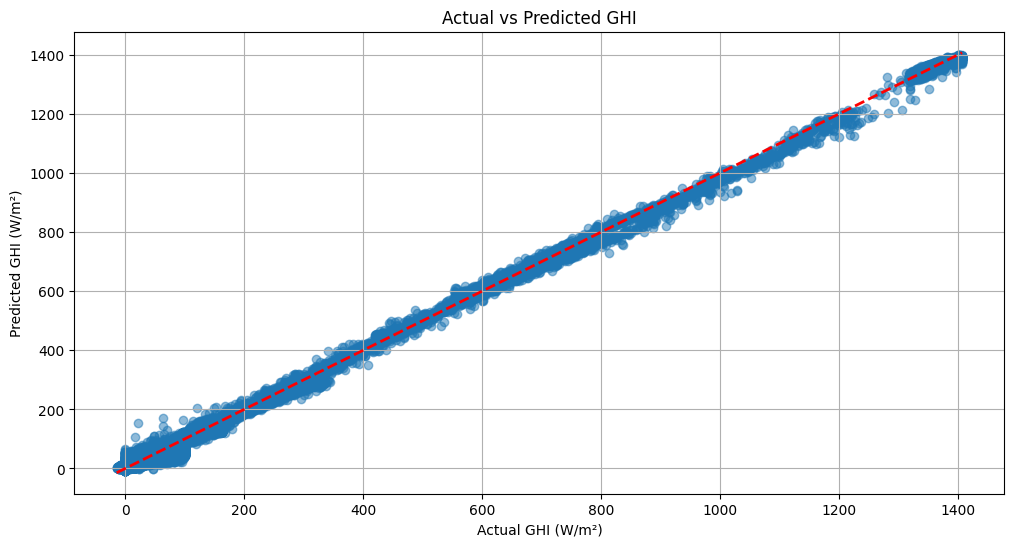

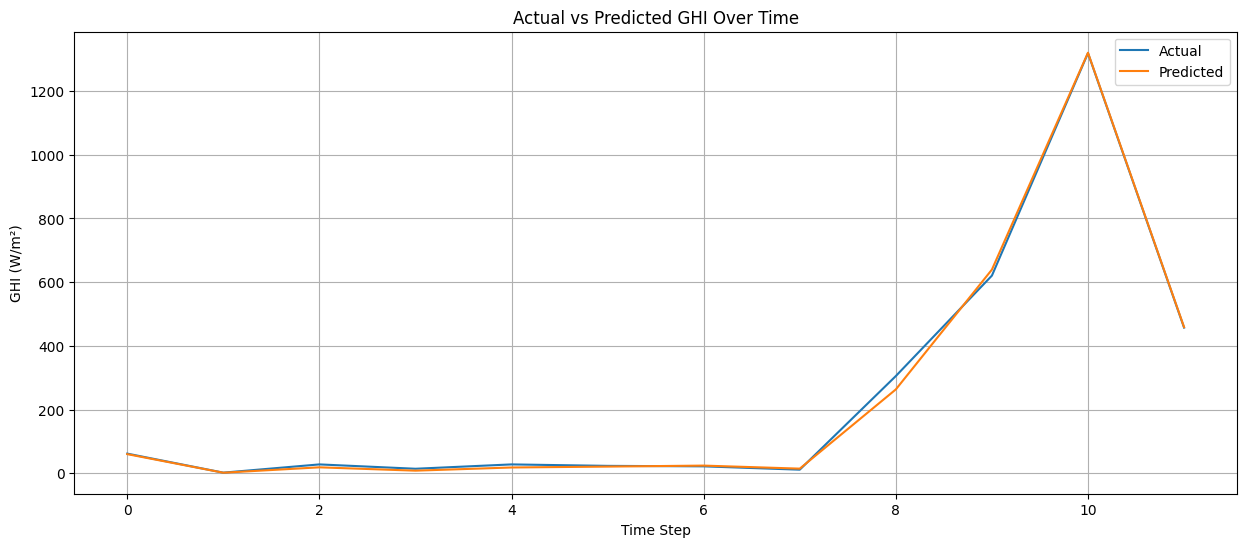

In [9]:
# Plot actual vs predicted values
plt.figure(figsize=(12, 6))
plt.scatter(test_targets_flat, test_predictions_flat, alpha=0.5)
plt.plot([test_targets_flat.min(), test_targets_flat.max()], 
         [test_targets_flat.min(), test_targets_flat.max()], 'r--', lw=2)
plt.xlabel('Actual GHI (W/m²)')
plt.ylabel('Predicted GHI (W/m²)')
plt.title('Actual vs Predicted GHI')
plt.grid(True)
plt.show()

# Plot time series for a sample sequence
plt.figure(figsize=(15, 6))
sample_idx = 0  # You can change this to see different sequences
plt.plot(test_targets[sample_idx], label='Actual')
plt.plot(test_predictions[sample_idx], label='Predicted')
plt.xlabel('Time Step')
plt.ylabel('GHI (W/m²)')
plt.title('Actual vs Predicted GHI Over Time')
plt.legend()
plt.grid(True)
plt.show()

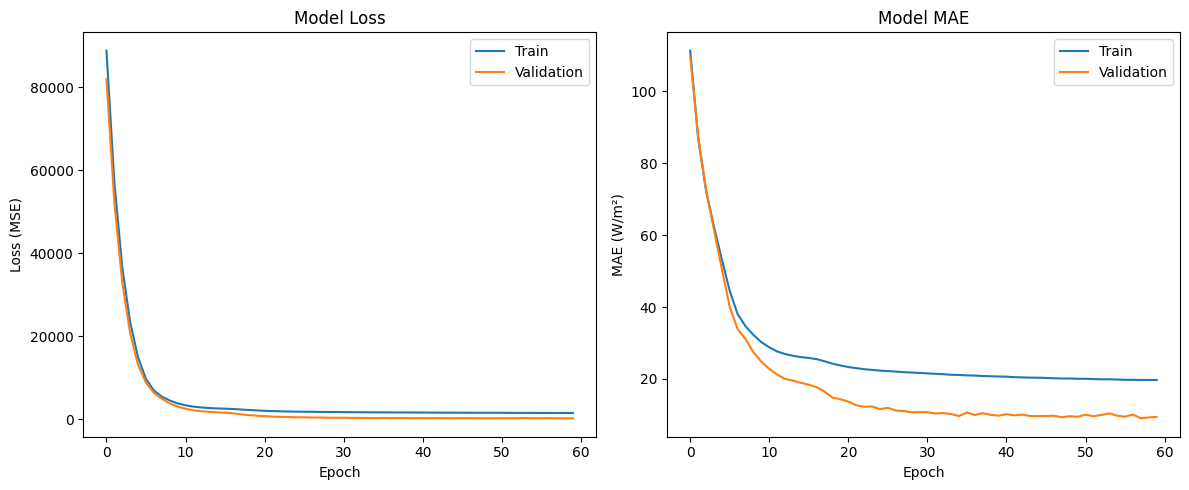

In [10]:
# Plot training history
plt.figure(figsize=(12, 5))

# Plot training & validation loss values
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Train')
plt.plot(history.history['val_loss'], label='Validation')
plt.title('Model Loss')
plt.ylabel('Loss (MSE)')
plt.xlabel('Epoch')
plt.legend()

# Plot training & validation MAE values
plt.subplot(1, 2, 2)
plt.plot(history.history['mae'], label='Train')
plt.plot(history.history['val_mae'], label='Validation')
plt.title('Model MAE')
plt.ylabel('MAE (W/m²)')
plt.xlabel('Epoch')
plt.legend()

plt.tight_layout()
plt.show()